# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

In [2]:
df = pd.read_csv('/content/data.csv')
print(df.shape) # 400 input-output combinations for the total dataset
df.head(df.shape[0])

(400, 3)


,X,Y,LABEL
0,79,-9,4
1,71,-17,3
2,-21,85,4
3,47,-51,2
4,95,-61,3
...,...,...,...
395,-42,43,2
396,-99,65,1
397,-44,30,2
398,-71,10,0


In [3]:
# a function for 1-hot encoding the output labels

def normalize(input):
  if input == 0:
    return [1,0,0,0,0]
  elif input == 1:
    return [0,1,0,0,0]
  elif input == 2:
    return [0,0,1,0,0]
  elif input == 3:
    return [0,0,0,1,0]
  elif input == 4:
    return [0,0,0,0,1]

In [4]:
X1 = df["X"].values.tolist()
X2 = df["Y"].values.tolist()
Y = df["LABEL"].values.tolist()

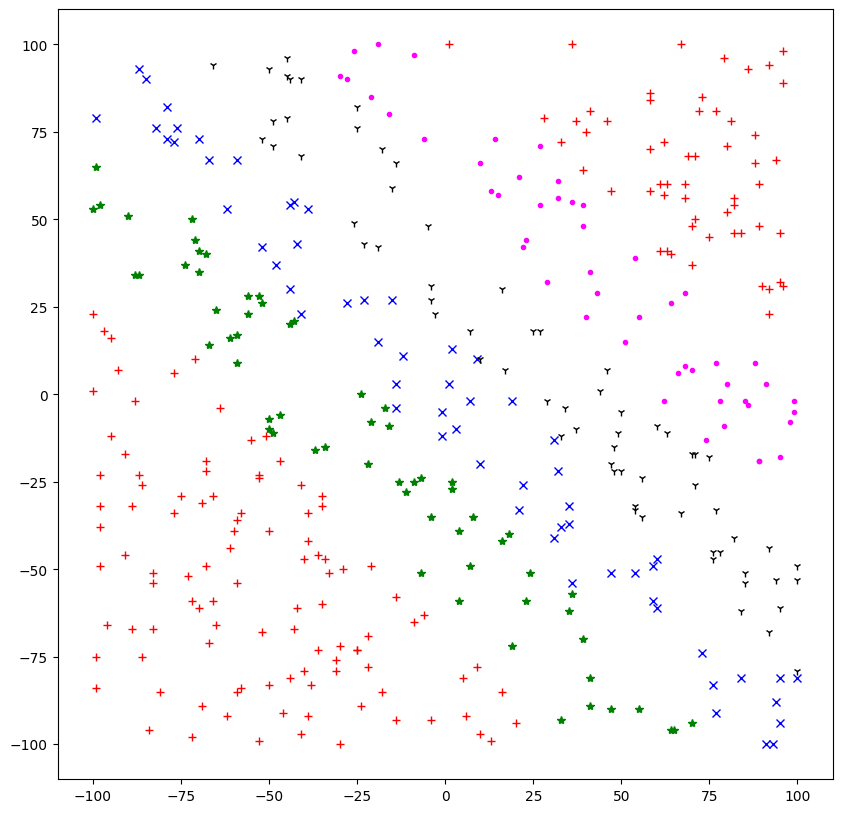

In [5]:
# plotting all points

plt.figure(figsize=(10,10))
for i in range(len(Y)):
    if Y[i] == 0:
        plt.plot(X1[i], X2[i], c="red", marker="+")
    elif Y[i] == 1:
        plt.plot(X1[i], X2[i], c="green", marker="*")
    elif Y[i] == 2:
        plt.plot(X1[i], X2[i], c="blue", marker="x")
    elif Y[i] == 3:
        plt.plot(X1[i], X2[i], c="black", marker="1")
    elif Y[i] == 4:
        plt.plot(X1[i], X2[i], c="magenta", marker=".")
plt.show()

In [6]:
features = list(zip(X1, X2)) #zipping the 2 input features into a list

features_np = np.array(features) #converting the list into a numpy array

In [7]:
 # normalizing the output labels to be one-hot encoded and
 # turning it into a numpy array

Y2 = np.array([normalize(i) for i in Y])

In [8]:
# dividing the total set into training (300) & testing (100) sets

features_train = features_np[:300]
Y2_train = Y2[:300]

features_test = features_np[300:]
Y2_test = Y2[300:]

# Neural Network - Training & testing

In [24]:
class NeuralNetwork(object):
    def __init__(self, inputLayerNeurons = 2, hidden1LayerNeurons = 20, hidden2LayerNeurons = 20, hidden3LayerNeurons = 20, outLayerNeurons = 5, learning_rate = 0.01, activation_type: str = 'sigmoid'):

        self.activation_type = activation_type
        self.learning_rate = learning_rate

        # random weight initialization
        self.W_H1I = np.random.randn(inputLayerNeurons, hidden1LayerNeurons)
        self.W_H2H1 = np.random.randn(hidden1LayerNeurons, hidden2LayerNeurons)
        self.W_H3H2 = np.random.randn(hidden2LayerNeurons, hidden3LayerNeurons)
        self.W_OH3 = np.random.randn(hidden3LayerNeurons, outLayerNeurons)

        # random bias initialization
        self.biases = [
            np.random.randn(hidden1LayerNeurons),
            np.random.randn(hidden2LayerNeurons),
            np.random.randn(hidden3LayerNeurons),
            np.random.randn(outLayerNeurons)
        ]

    def activation(self, x, der=False):
        if self.activation_type == 'sigmoid':
            if der == True:
                return np.exp(-x) / (1 + np.exp(-x))**2 # return x * (1-x)
            else:
                return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)

        if self.activation_type == "tanh":
            if der == True:
                return 1 - (np.tanh(x))**2 # 1 - (tanh(x))^2
            else:
                return np.tanh(x)

        if self.activation_type == "relu":
            if der == True:
                return np.where(x > 0, 1, 0)
            else:
                return np.maximum(0, x)

        if self.activation_type == "gaussian":
            if der == True:
                return -(2 * x * np.exp(-x**2)) # -2xe^(-x^2)
            else:
                return np.exp(-x**2)  # e^(-x^2)

    def softmax(self, x):
      exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  #for numerical stability
      return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_H1I) + self.biases[0]
        self.hidden1_output = self.activation(hidden1_input)

        hidden2_input = np.dot(self.hidden1_output, self.W_H2H1) + self.biases[1]
        self.hidden2_output = self.activation(hidden2_input)

        hidden3_input = np.dot(self.hidden2_output, self.W_H3H2) + self.biases[2]
        self.hidden3_output = self.activation(hidden3_input)

        output_input = np.dot(self.hidden3_output, self.W_OH3) + self.biases[3]

        pred = self.softmax(output_input)
        #print(pred)
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        #output_delta = self.learning_rate * output_error * self.activation(pred, der=True)
        output_delta = self.learning_rate * output_error

        hidden3_error = output_delta.dot(self.W_OH3.T)
        hidden3_delta = self.learning_rate * hidden3_error * self.activation(self.hidden3_output, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H3H2.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.activation(self.hidden2_output, der=True)

        hidden1_error = hidden2_delta.dot(self.W_H2H1.T)
        hidden1_delta = self.learning_rate * hidden1_error * self.activation(self.hidden1_output, der=True)

        self.W_H1I += X.T.dot(hidden1_delta)
        self.W_H2H1 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_H3H2 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_OH3 += self.hidden3_output.T.dot(output_delta)

        self.biases[0] += self.learning_rate * np.sum(hidden1_delta, axis=0)
        self.biases[1] += self.learning_rate * np.sum(hidden2_delta, axis=0)
        self.biases[2] += self.learning_rate * np.sum(hidden3_delta, axis=0)
        self.biases[3] += self.learning_rate * np.sum(output_delta, axis=0)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)

Epoch: 0, error: 8.074410726715827
Epoch: 10000, error: 1.4902510143483734
Epoch: 20000, error: 1.4902510143483734
Epoch: 30000, error: 1.4902510143483734
Epoch: 40000, error: 1.4902510143483734
Epoch: 50000, error: 1.4902510143483734
Epoch: 60000, error: 1.4902510143483734
Epoch: 70000, error: 1.4902510143483734
Epoch: 80000, error: 1.4902510143483734
Epoch: 90000, error: 1.4902510143483734


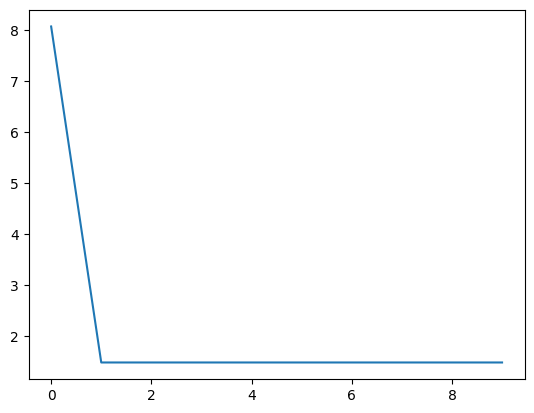

In [27]:
NN = NeuralNetwork(activation_type = 'relu')

err_list = []

def crossentropy(pred, Y_true):
    pred = np.clip(pred, 1e-4, 1.0 - 1e-4)
    return np.mean(-np.sum(Y_true * np.log(pred), axis=1))

for i in range(100000):
    NN.train(features_train,Y2_train)
    err = crossentropy(NN.feedForward(features_train), Y2_train)
    #err = np.mean(np.square(Y2_train - NN.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

plt.plot(err_list)
plt.show()

Epoch: 0, error: 0.2341982145568929
Epoch: 10000, error: 0.08130125891060741
Epoch: 20000, error: 0.07722613098633678
Epoch: 30000, error: 0.07843735563720279
Epoch: 40000, error: 0.0716112312103157
Epoch: 50000, error: 0.07094449950029096
Epoch: 60000, error: 0.04985532411266589
Epoch: 70000, error: 0.04507112396921168
Epoch: 80000, error: 0.08715569673065465
Epoch: 90000, error: 0.03992103570888603


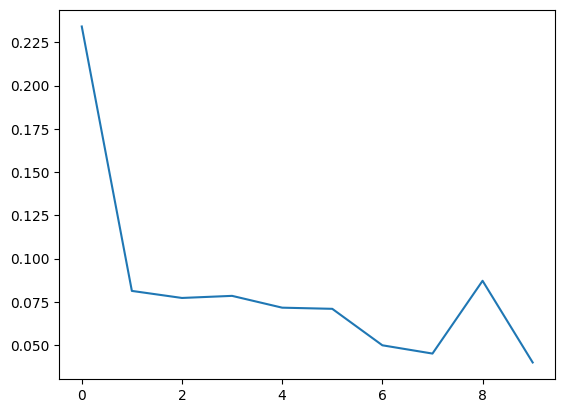

In [10]:
NN = NeuralNetwork(activation_type = 'sigmoid')
#NN = NeuralNetwork(activation_type ='tanh')
#NN = NeuralNetwork(activation_type = 'gaussian')
#NN = NeuralNetwork(activation_type = 'relu')

err_list = []

for i in range(100000):
    NN.train(features_train,Y2_train)
    err = np.mean(np.square(Y2_train - NN.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

plt.plot(err_list)
plt.show()

In [11]:
# stores a dict with the probability of each class with its class name

def getProb(pred):
    return {f'Class-{index}': p*100 for index, p in enumerate(pred)}

In [12]:
# returns the dict key with the highest probablity

def getClass(dict):
  max_key = max(dict, key=dict.get)
  return (max_key)

In [13]:
# testing a random input

pred = NN.feedForward([[75,-33]])

print(pred[0])
print(getProb(pred[0]))
print(getClass(getProb(pred[0])))

[2.12488499e-24 2.02290929e-35 4.20995985e-05 9.99957634e-01
 2.66337185e-07]
{'Class-0': 2.1248849866355854e-22, 'Class-1': 2.022909293192687e-33, 'Class-2': 0.004209959845682995, 'Class-3': 99.9957634064358, 'Class-4': 2.663371851804563e-05}
Class-3


# Performance Metrics

In [14]:
predictions = NN.feedForward(features_test)
#print(f"Predictions: {predictions}")

# Calculate recall and F1 score
Y_true = np.argmax(Y2_test, axis=1)
Y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
print(f"Overall Accuracy: {accuracy}")

precision = precision_score(Y_true, Y_pred, average=None)
print("Precision for each class:")
for i, score in enumerate(precision):
    print(f"Class {i}: {score}")

recall = recall_score(Y_true, Y_pred, average='macro')
print(f"Recall: {recall}")

f1 = f1_score(Y_true, Y_pred, average='macro')
print(f"F1 Score overall: {f1}")

Overall Accuracy: 0.85
Precision for each class:
Class 0: 0.9487179487179487
Class 1: 0.75
Class 2: 0.8125
Class 3: 0.7894736842105263
Class 4: 0.7857142857142857
Recall: 0.8158974358974358
F1 Score overall: 0.8143064116748328


In [15]:
# f1 score fr each class

f1_scores = f1_score(Y_true, Y_pred, average=None)

print("F1 Scores for each class:")
for i, score in enumerate(f1_scores):
    print(f"Class {i}: {score}")

F1 Scores for each class:
Class 0: 0.9736842105263158
Class 1: 0.75
Class 2: 0.7222222222222223
Class 3: 0.8108108108108109
Class 4: 0.8148148148148148


# Documentation

**Modifications made:**

1. `outLayerNeurons` value changed from 1 to `5` for accomodating 5 seperate classes.
2. Added a variable to hold the 2nd and 3rd hidden layer neuron counts: `hidden2LayerNeurons` & `hidden2LayerNeurons` respectively.
3. Additional 2 weight matrices were introduced to handle the weights between Hidden1-Hidden2 & Hidden2-Hidden3 connections: `W_H2H1`, `W_H3H2`.
4. For handling biases a `biases` list was constructed, which contained lists of varying sizes, where the sizes vary with the number of neurons in each layer.
5. Added 4 more activation functions, `tanh`, `reLU` & `gaussian` for testing purposes. reLU proved the least effective due to out dataset having a huge amount of negatice input features. Addtionally, `softmax` was used in the output layer neurons due to the problem being a classification one.
6. During forward propagation, 4 new calculated terms were needed, `hidden2_input`, `hidden2_output`, `hidden3_input`, `hidden3_output`. These were added for the additional 2 hidden layers to the network.
7. In the same way, during backpropagation, `hidden3_error`, `hidden2_error`, `hidden3_delta`, `hidden2_delta` were introduced.
8. Due to our new addition of baises, they also needed to be adjusted accordingly.

**Challenges**:

1. Adding 2 additional layers to the model required extra calculations and code to be implemented which proved to be difficult at the time.
2. Calculating the backpropagation formula along with the weight, bias adjustments lead to mistakes during the initial stages but were soon remedied.

# Result & Analysis

In [16]:
# confusion matrix

def conf(Y_true, Y_pred, c = 'magma'):
    conf_matrix = confusion_matrix(Y_true, Y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=c)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
# ROC graph

def roc_plot(Y2_test, Y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(Y2_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(Y2_test[:, i], Y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #ROC curve for each class
    for i in range(Y2_test.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
predictions = NN.feedForward(features_test)

Y_true = np.argmax(Y2_test, axis=1)
Y_pred = np.argmax(predictions, axis=1)

Confusion Matrix:
[[37  0  0  0  0]
 [ 1  9  2  0  0]
 [ 0  3 13  4  0]
 [ 0  0  0 15  3]
 [ 1  0  1  0 11]]


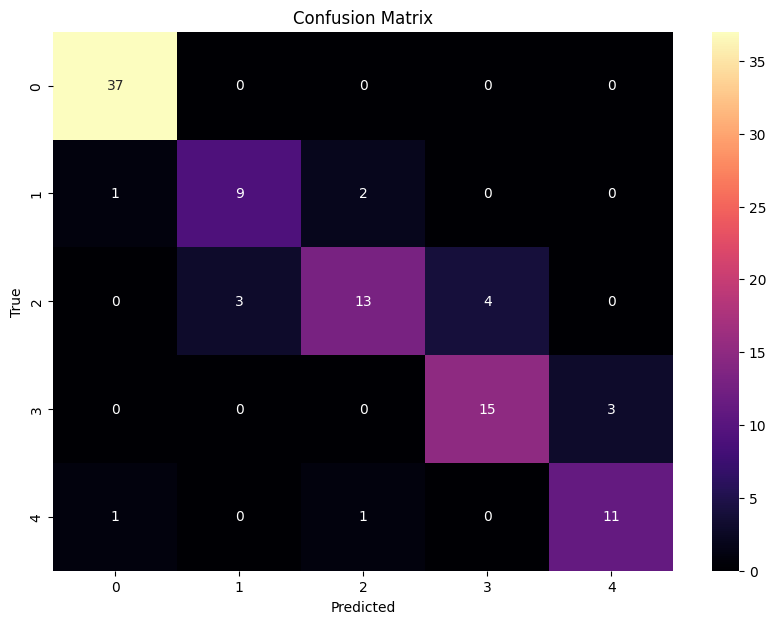

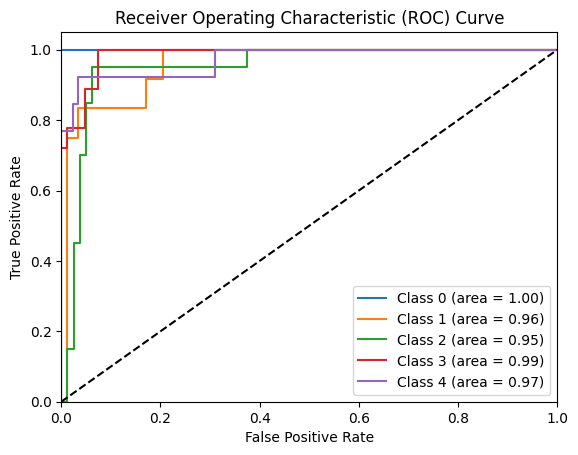

In [19]:
conf(Y_true, Y_pred)

print()

roc_plot(Y2_test, predictions)

In [20]:
NN_1 = NeuralNetwork(inputLayerNeurons = 2, hidden1LayerNeurons = 60, hidden2LayerNeurons = 60, hidden3LayerNeurons = 60, outLayerNeurons = 5, learning_rate = 0.001, activation_type= 'sigmoid')

for i in range(100000):
    NN_1.train(features_train,Y2_train)
    err = np.mean(np.square(Y2_train - NN_1.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

Epoch: 0, error: 0.21814832624731612
Epoch: 10000, error: 0.05681658757044027
Epoch: 20000, error: 0.051118071064127094
Epoch: 30000, error: 0.04750538150757605
Epoch: 40000, error: 0.044939537869163756
Epoch: 50000, error: 0.04298694582048833
Epoch: 60000, error: 0.041425186944131186
Epoch: 70000, error: 0.0401283973558668
Epoch: 80000, error: 0.03902001174125255
Epoch: 90000, error: 0.038050559195926655


In [21]:
predictions1 = NN_1.feedForward(features_test)

Y_true1 = np.argmax(Y2_test, axis=1)
Y_pred1 = np.argmax(predictions1, axis=1)

Confusion Matrix:
[[35  2  0  0  0]
 [ 2 10  0  0  0]
 [ 0  3 16  1  0]
 [ 0  0  1 13  4]
 [ 4  0  0  0  9]]


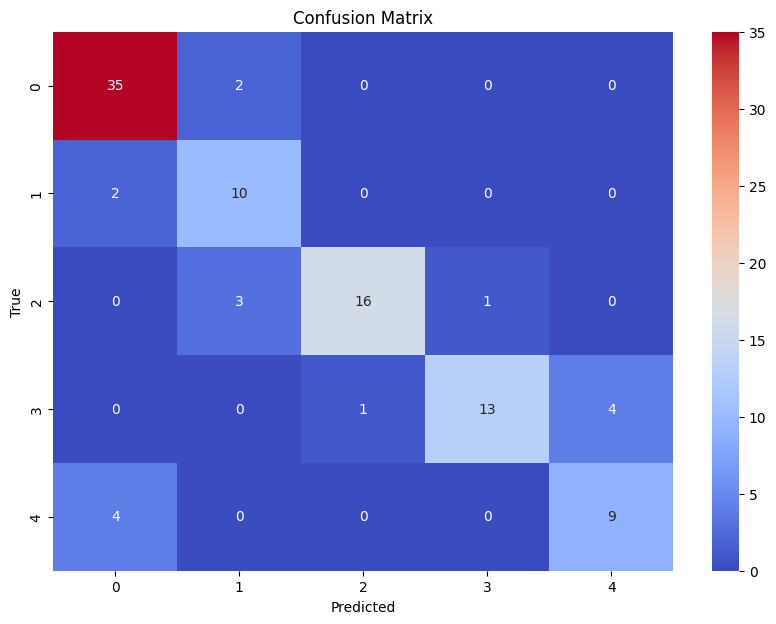

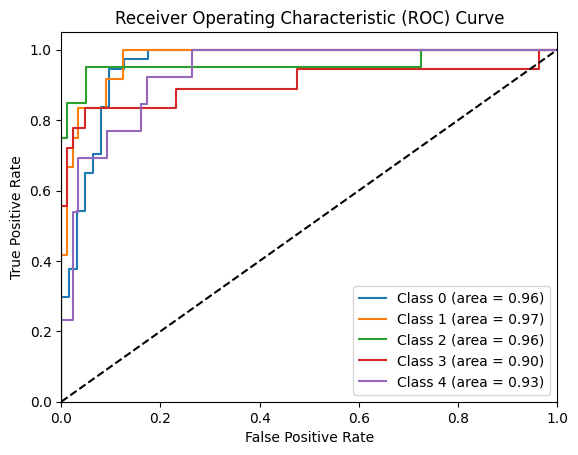

In [22]:
conf(Y_true1, Y_pred1, 'coolwarm')

print()

roc_plot(Y2_test, predictions1)

In [23]:
accuracy = accuracy_score(Y_true1, Y_pred1)
print(f"Overall Accuracy: {accuracy}")

precision = precision_score(Y_true1, Y_pred1, average=None)
print("Precision for each class:")
for i, score in enumerate(precision):
    print(f"Class {i}: {score}")

recall = recall_score(Y_true1, Y_pred1, average='macro')
print(f"Recall: {recall}")

f1 = f1_score(Y_true1, Y_pred1, average='macro')
print(f"F1 Score overall: {f1}")

Overall Accuracy: 0.83
Precision for each class:
Class 0: 0.8536585365853658
Class 1: 0.6666666666666666
Class 2: 0.9411764705882353
Class 3: 0.9285714285714286
Class 4: 0.6923076923076923
Recall: 0.7987618387618388
F1 Score overall: 0.8015698390698391


Here it can be observed that after training the model again on the same train-test split, but with different number of neurons in the hidden layers, the overall accuracy slightly decreased from `85%` to `83%`. This may be due to the dataset being very small in size and the 2nd model using a smaller learning rate in comparison.

# Conclusion

**Summary:**

Overall, our 3-hidden layer neural network was able to classify the input into 5 seperate classes with recall and F1 scores of above 0.74, when all hidden layers had 20 neurons each. The total accuracy achieved was 85% using sigmoid as the activation. Our dataset was very small, with a training set of 300 combinations and 100 for testing.

**Challenges & Achievements**

Despite the simple dataset, the model may have been overfitted due to using too many neurons in the hidden layers and hence the accuracy may be low for testing data. By adjusting the learning rate and internel parameters, the model may perform better for larger datasets. As our dataset consisted of both negative and positive integers, tanh and sigmoid activations will perform the best as both of them limit the output to either [0, 1] or the [-1, 1] range. In this assignment we used sigmoid, as tanh had fluctuations in its total erros during training. Moreover since our output labels were 1-hot encoded, sigmoid performed decently.

**Improvements:**

Rather than implementing simple patterns similar to our custom data, this model can also be used to classify images belonging to different classes. Since, images are stored as pixel values during runtime, we can use ReLU as the activation function, since pixels only have values in the range [0, 255]. ReLU is already implemented in the model but it performs poorly for our dataset due to us having negative values input features. Both learning rate and the hidden layer neuron counts can be experimented with to achieve the perfect balance  